## Laboratory work 1

The associated Legendre functions are bounded solutions to the following eigenfunction problem:

\begin{equation}
  \begin{cases}
    \frac{d}{dx}(1-x^2)\frac{dU(x)}{dx} - \frac{m^2}{1-x^2}U(x) = -\lambda U(x),\quad -1<x<1\\
    \lim_{x\to\pm1}(1-x^2)U'(x) = 0
  \end{cases}
\end{equation}

It is known that the solution to this problem will be eigenfunctions and eigenvalues ​​of the following form:

\begin{equation}
  U_n(x) = P_n^m(x),\; \text{where} \; m = 1
\end{equation}
\begin{equation}
  \lambda_n = n(n+1), \; n \in \mathbb {N}, \; n \geq m
\end{equation}

In this lab I need to numerically find for a given differential operator 5 eigenfunctions that correspond to the minimum eigenvalues.


Extras:
* To solve the SLAE, the sweep method was implemented
* Errors are calculated and the order of approximation is shown

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lpmv
from sympy.solvers import solve

In [ ]:
#some important constants and creation of segment splitting

h = 0.0002
eps = 0.000000001

def x_split(h):
  x = np.linspace(-1, 1, int(2.0 / h) + 1)
  x = x[:-1] + h / 2
  x_h_p =  x + h / 2
  x_h_m = x - h / 2
  return x, x_h_p, x_h_m

x, x_h_p, x_h_m = x_split(h)
U_0 = np.linspace(-1, 3, len(x))

U_0 = U_0 / np.linalg.norm(U_0)

# Проверка расстояний
def check_distance(array, h, eps):
    distances = np.diff(array)  # вычисляем разности между соседними узлами
    return np.all(np.abs(distances - h) < eps)

# Проверяем, равны ли расстояния h
is_x_spacing_correct = check_distance(x, h, eps)
is_x_h_p_spacing_correct = check_distance(x_h_p, h, eps)
is_x_h_m_spacing_correct = check_distance(x_h_m, h, eps)

# Выводим результат проверки
print("Проверка расстояний:")
print(f"Расстояние между элементами в x равно h: {is_x_spacing_correct}")
print(f"Расстояние между элементами в x_h_p равно h: {is_x_h_p_spacing_correct}")
print(f"Расстояние между элементами в x_h_m равно h: {is_x_h_m_spacing_correct}")

Проверка расстояний:
Расстояние между элементами в x равно h: True
Расстояние между элементами в x_h_p равно h: True
Расстояние между элементами в x_h_m равно h: True


In [ ]:
#accurate verification solution

def U_accurate(x, n, U_0):
  U_accurate = lpmv(1, n, x)/np.linalg.norm(lpmv(1, n, x))
  #eigenfunctions are defined up to sign, so a check is needed
  if U_accurate[1] * U_0 < 0:
    U_accurate = -U_accurate
  return U_accurate

In [ ]:
#implementation of the sweep method

def ai(x, h):
  ai = np.zeros(len(x))
  ai = -(1 - (x - h/2)**2) / (h*h)
  ai[-1] = - (1 - (1-h)*(1-h)) / (h*h)
  return ai

def bi(x, h):
  bi = np.zeros(len(x))
  bi = (1 - (x - h/2)**2) / (h*h) + (1 - (x + h/2)**2) / (h*h) + 1/(1 - x**2)
  bi[0] = (1 - (1-h)*(1-h))/(h*h)
  bi[-1] = (1 - (1-h)*(1-h))/(h*h)
  return bi

def ci(x, h):
  ci = np.zeros(len(x))
  ci = -(1 - (x + h/2)**2) / (h*h)
  ci[0] = - (1 - (1-h)*(1-h))/(h*h)
  return ci

def forward_step(a, b, c, d):
  alpha_i, beta_i = [], []

  alpha_i += [-c[0] / b[0]]
  beta_i += [d[0] / b[0]]

  for i in range(1, len(b) - 1):
    y_i = b[i] + a[i]*alpha_i[-1]
    alpha_i += [-c[i] / y_i]
    beta_i += [(d[i] - a[i]*beta_i[-1]) / y_i]
  beta_i += [(d[-1] - a[-1]*beta_i[-1]) / (b[-1] + a[-1]*alpha_i[-1])]

  return alpha_i, beta_i

def back_step(alpha, beta):
  xi = []
  xi += [beta[-1]]
  for i in range(len(beta) - 2, -1, -1):
    xi += [alpha[i]*xi[-1] + beta[i]]
  xi.reverse()
  return xi

def sweep(a, b, c, U_n):
  alpha, beta = forward_step(a, b, c, U_n)
  U_new = back_step(alpha, beta)
  return U_new

In [ ]:
#approximation of a differential operator

def operator_L(U, h):
  L_U = []
  x, x_h_p, x_h_m = x_split(h)
  L_U = 1/(h*h) * ((1 - x_h_m[1:-1]**2)*(U[1:-1] - U[:-2]) + (1 - x_h_p[1:-1]**2)*(U[1:-1] - U[2:])) + U[1:-1] / (1-x[1:-1]**2)
  L_U = np.append(L_U, (1 - (1-h)*(1-h))/(h*h) * (U[-1] - U[-2]))
  L_U = np.insert(L_U, 0, (1 - (1-h)*(1-h))/(h*h) * (U[0] - U[1]))

  L_U = np.array(L_U)
  return L_U

#Rayleigh method

def rayleigh(U_0, lambda_n, eps, h):
  lambda_ex = 100
  U_0 /= (U_0.dot(U_0))**0.5
  while abs(lambda_n - lambda_ex) > eps:
    lambda_ex = lambda_n
    U_n = sweep(ai(x,h), bi(x,h) - lambda_n, ci(x,h), U_0)
    U_n = np.array(U_n)
    U_n /= (U_n.dot(U_n))**0.5
    lambda_n = ((operator_L(U_n, h)).dot(U_n)) / (U_n.dot(U_n))
    U_0 = U_n
  return lambda_n, U_0

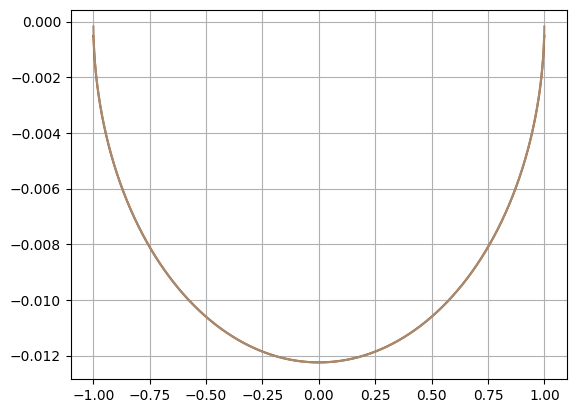

lambda_1 =  1.998750467174861


In [ ]:
#finding lambda_1

l, U = rayleigh(U_0, 1.9, eps, h)
plt.plot(x, U, color = '#9C4A1A')
plt.plot(x, U_accurate(x, 1, U[1]), color = '#A78B71')
plt.grid()
plt.show()
print("lambda_1 = ", l)

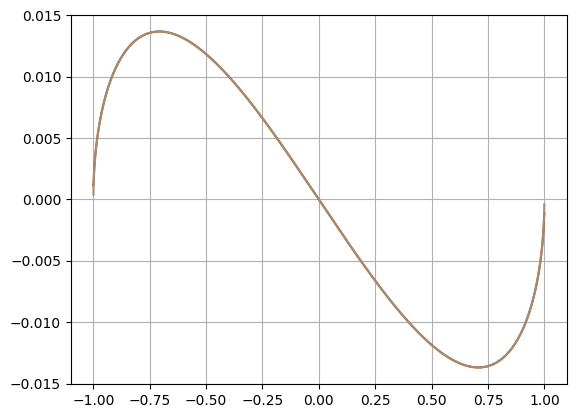

lambda_2 =  5.993736606669843


In [ ]:
#finding lambda_2

l, U = rayleigh(U_0, 5.9, eps, h)
plt.plot(x, U, color = '#9C4A1A')
plt.plot(x, U_accurate(x, 2, U[1]), color = '#A78B71')
plt.grid()
plt.show()
print("lambda_2 = ", l)

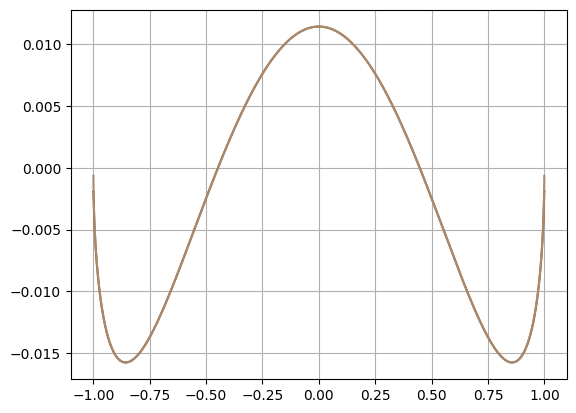

lambda_3 =  11.982400683752784


In [ ]:
#finding lambda_3

l, U = rayleigh(U_0, 11.9, eps, h)
plt.plot(x, U, color = '#9C4A1A')
plt.plot(x, U_accurate(x, 3, U[1]), color = '#A78B71')
plt.grid()
plt.show()
print("lambda_3 = ", l)

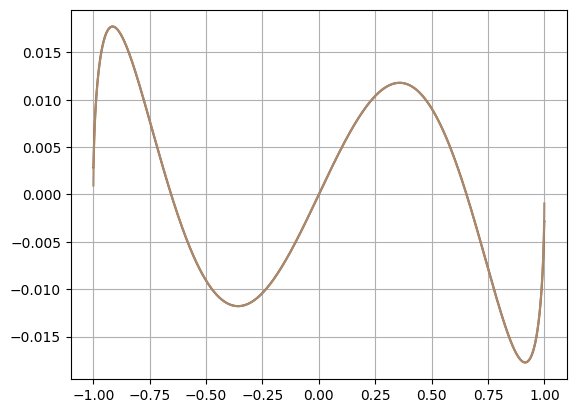

lambda_4 =  19.962121491822973


In [ ]:
#finding lambda_4

l, U = rayleigh(U_0, 19.9, eps, h)
plt.plot(x, U, color = '#9C4A1A')
plt.plot(x, U_accurate(x, 4, U[1]), color = '#A78B71')
plt.grid()
plt.show()
print("lambda_4 = ", l)

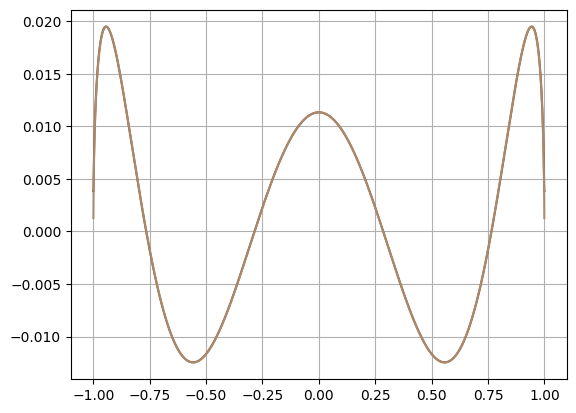

lambda_5 =  29.930197680120614


In [ ]:
#finding lambda_5

l, U = rayleigh(U_0, 29.9, eps, h)
plt.plot(x, U, color = '#9C4A1A')
plt.plot(x, U_accurate(x, 5, U[1]), color = '#A78B71')
plt.grid()
plt.show()
print("lambda_5 = ", l)

##A few words about the order of approximation

In this work, the grid analogue of the operator has the form:

\begin{equation}
  (LU)_i =
  \begin{cases}
    \frac{1}{h^2}(1 - (1-h)^2)(U_0 - U_1) & \text{i = 0}\\
    (1-x^2_{i - \frac{1}{2}})(U_i - U_{i-1}) + (1 - x^2_{i + \frac{1}{2}})(U_i - U_{i+1}) + \frac{1}{1-x_i^2}U_i & \text{i=[1;n-1]}\\
    \frac{1}{h^2}(1 - (1-h)^2)(U_n - U_{n-1}) & \text{i = n}
  \end{cases}
\end{equation}

The boundary conditions have a first order of approximation. You can increase the order by approximating the derivatives at three points. But in this case, the matrix is ​​not tridiagonal and the sweep method cannot be applied.

In this solution we will leave the first order, since the sweep method was implemented.


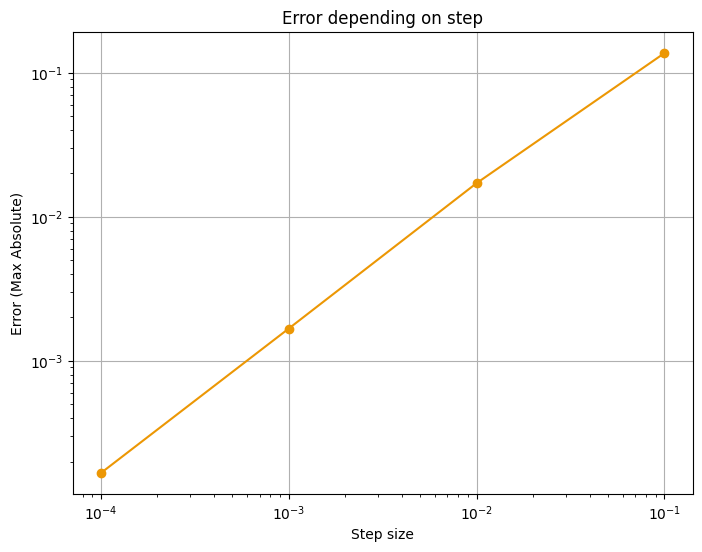

In [ ]:
steps = [0.1, 0.01, 0.001, 0.0001]

errors = []

for step in steps:
    x, x_h_p, x_h_m = x_split(step)
    U_0 = np.linspace(-1, 2, len(x))
    U_0 = U_0 / np.linalg.norm(U_0)
    l, y_values = rayleigh(U_0, 2.2, eps, step)
    exact_values = U_accurate(x, 1, U[0])
    st = (int)(0.1 / step)
    error = np.max(np.abs(np.abs(y_values[::st]) - np.abs(exact_values[::st])))
    errors.append(error)

plt.figure(figsize=(8, 6))
plt.plot(steps, errors, marker='o', linestyle='-', color='#EC9704')
plt.xlabel("Step size")
plt.ylabel("Error (Max Absolute)")
plt.xscale("log")
plt.yscale("log")
plt.title("Error depending on step")
plt.grid(True)
plt.show()